<a href="https://colab.research.google.com/github/Kabindra02/Flood_Severity_index/blob/main/notebook27a1c11008.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

kabindradhakal_flooooodood_path = kagglehub.dataset_download('kabindradhakal/flooooodood')

print('Data source import complete.')


In [ ]:
!pip install -U keras-tuner
!pip install keras==2.12.0
!pip install keras-tcn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.8 MB/s eta 0:00:0000:010:01
  Attempting uninstall: keras
    Found existing installation: keras 3.10.0
    Uninstalling keras-3.10.0:
      Successfully uninstalled keras-3.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-hub 0.21.1 requires keras>=3.5, but you have keras 2.12.0 which is incompatible.
tensorflow 2.19.0 requires keras>=3.5.0, but you have keras 2.12.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.2 MB/s eta 0:00:0000:010:01
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0


In [ ]:
import numpy as np
import pandas as pd
import os
import shutil
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tcn import TCN
import keras_tuner as kt
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    classification_report,
    confusion_matrix
)

In [ ]:
df = pd.read_csv('/kaggle/input/flooooodood/df_with_flood_labels.csv')

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

In [ ]:
features = [
    'Daily flow Rate', 'Gauge height flow', '24h accumulated',
    'sm_top_0_10cm', 'sm_10_40cm', 'sm_change_rate',
    'saturation_index', 'flow_change_rate', 'flow_lag_1d',
    'flow_lag_2d', 'rain_sum_3d', 'rain_sum_5d', 'rain_sum_7d', 'API'
]
target = 'flood_final'

In [ ]:
X_raw = df[features].values
y_raw = df[target].values

In [ ]:
def create_dataset(X, y, time_steps=5):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

WINDOW_SIZE = 5
X_series, y_series = create_dataset(X_raw, y_raw, WINDOW_SIZE)

In [ ]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_series),
    y=y_series
)
class_weight_dict = dict(enumerate(class_weights))
print(f"Class Weights (0-3): {class_weight_dict}")

Class Weights (0-3): {0: np.float64(0.26771383832452533), 1: np.float64(9.241554054054054), 2: np.float64(8.5484375), 3: np.float64(25.328703703703702)}


In [ ]:
# One-hot encode target
y_cat = to_categorical(y_series, num_classes=4)

In [ ]:
#defining model
def build_model(hp):
    input_layer = Input(shape=(WINDOW_SIZE, len(features)))

    # TCN Block
    tcn_out = TCN(
        nb_filters=hp.Int('nb_filters', 32, 128, step=32),
        kernel_size=hp.Choice('kernel_size', [2, 3]),
        dilations=[1, 2, 4, 8, 16],
        return_sequences=False,
        dropout_rate=hp.Float('dropout', 0.1, 0.5, step=0.1)
    )(input_layer)

    output_layer = Dense(4, activation='softmax')(tcn_out)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('lr', 1e-4, 1e-2, sampling='log')),
        loss='categorical_crossentropy',
        metrics=['accuracy'] # We monitor accuracy, but rely on class_weights for balance
    )
    return model

In [ ]:
# Key improvements for time-series cross-validation

for fold_idx, (train_ix, test_ix) in enumerate(tscv.split(X_series)):
    print(f"--- Fold {fold_idx + 1} ---")

    # 1. Split Data
    X_train_fold_raw, X_test_fold_raw = X_series[train_ix], X_series[test_ix]
    y_train_fold, y_test_fold = y_cat[train_ix], y_cat[test_ix]

    # 2. Pipeline Scaling (Fit on Train, Apply to Test)
    scaler = MinMaxScaler()
    N_train, T, F = X_train_fold_raw.shape
    X_train_flat = X_train_fold_raw.reshape(N_train * T, F)
    scaler.fit(X_train_flat)
    X_train_fold = scaler.transform(X_train_flat).reshape(N_train, T, F)

    N_test, _, _ = X_test_fold_raw.shape
    X_test_flat = X_test_fold_raw.reshape(N_test * T, F)
    X_test_fold = scaler.transform(X_test_flat).reshape(N_test, T, F)

    # 3. SEQUENTIAL VALIDATION SPLIT FOR TUNING
    val_size = int(len(X_train_fold) * 0.2)
    X_train_tune = X_train_fold[:-val_size]
    X_val_tune = X_train_fold[-val_size:]
    y_train_tune = y_train_fold[:-val_size]
    y_val_tune = y_train_fold[-val_size:]

    # 4. Hyperparameter Tuning
    tuner_root = '/kaggle/working/tcn_tuning'
    project_path = f'fold_{fold_idx}'
    fold_dir = os.path.join(tuner_root, project_path)

    if os.path.exists(fold_dir):
        shutil.rmtree(fold_dir)

    tuner = kt.RandomSearch(
        build_model,
        objective='val_accuracy',
        max_trials=10,
        directory=tuner_root,
        project_name=project_path
    )

    # Use sequential validation data instead of random split
    tuner.search(
        X_train_tune, y_train_tune,
        validation_data=(X_val_tune, y_val_tune),  # SEQUENTIAL VALIDATION
        epochs=30,  # Consistent epochs
        batch_size=32,
        class_weight=class_weight_dict,
        callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
        verbose=0
    )

    best_hp = tuner.get_best_hyperparameters(1)[0]

    # 5. Retrain on FULL training fold with best hyperparameters
    model = build_model(best_hp)

    # Option A: Retrain with validation monitoring (recommended)
    history = model.fit(
        X_train_tune, y_train_tune,
        validation_data=(X_val_tune, y_val_tune),
        epochs=30,  # Same as tuning
        batch_size=32,
        class_weight=class_weight_dict,
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        ],
        verbose=0
    )

    # Option B: Retrain on full train fold without validation (alternative)
    # model.fit(
    #     X_train_fold, y_train_fold,
    #     epochs=30,  # Use same epochs or use early stopping epochs from tuning
    #     batch_size=32,
    #     class_weight=class_weight_dict,
    #     verbose=0
    # )

    # 6. Evaluate on held-out test fold
    y_pred_probs = model.predict(X_test_fold, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test_fold, axis=1)

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # R² can be misleading for classification - consider removing or using for ordinal regression
    # r2 = r2_score(y_true, y_pred)

    print(f"Fold {fold_idx+1}: Acc={acc:.4f} | F1={f1:.4f} | MAE={mae:.4f} | RMSE={rmse:.4f}")

    nested_results.append({
        'fold': fold_idx+1,
        'acc': acc,
        'f1': f1,
        'mae': mae,
        'rmse': rmse
    })

    # Cleanup
    try:
        shutil.rmtree(fold_dir)
    except:
        pass

    tf.keras.backend.clear_session()


--- Fold 1 ---
Fold 1: Acc=0.5840 | F1=0.6899 | MAE=1.0681 | RMSE=1.7212
--- Fold 2 ---
Fold 2: Acc=0.8957 | F1=0.9327 | MAE=0.1844 | RMSE=0.6145
--- Fold 3 ---
Fold 3: Acc=0.8507 | F1=0.8734 | MAE=0.1778 | RMSE=0.4847
--- Fold 4 ---
Fold 4: Acc=0.7607 | F1=0.8390 | MAE=0.2492 | RMSE=0.5186
--- Fold 5 ---
Fold 5: Acc=0.6663 | F1=0.7805 | MAE=0.9506 | RMSE=1.6638


In [ ]:
print("\n=== Final Results ===")
results_df = pd.DataFrame(nested_results)
print(results_df)
print("\nAverages:")
print(results_df.mean(numeric_only=True))


=== Final Results ===
   fold       acc        f1       mae      rmse        r2
0     1  0.682766  0.757747  0.549945  1.088307 -2.285632
1     2  0.931943  0.951253  0.084523  0.352192 -1.221088
2     3  0.713502  0.783024  0.297475  0.567120  0.123383
3     4  0.894621  0.929405  0.171240  0.556372 -1.461643
4     5  0.828760  0.885164  0.204171  0.525946 -0.883683
5     1  0.583974  0.689908  1.068057  1.721243       NaN
6     2  0.895719  0.932668  0.184413  0.614497       NaN
7     3  0.850714  0.873388  0.177827  0.484672       NaN
8     4  0.760703  0.838998  0.249177  0.518590       NaN
9     5  0.666301  0.780517  0.950604  1.663847       NaN

Averages:
fold    3.000000
acc     0.780900
f1      0.842207
mae     0.393743
rmse    0.809279
r2     -1.145733
dtype: float64


In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

feature_names = features
baseline_preds = np.argmax(model.predict(X_test_fold), axis=1)
y_true = np.argmax(y_test_fold, axis=1)
baseline_acc = accuracy_score(y_true, baseline_preds)

importances = []

for f_idx, fname in enumerate(feature_names):
    X_perm = X_test_fold.copy()

    # Permute feature across samples (preserve temporal structure)
    perm = X_perm[:, :, f_idx].copy()
    np.random.shuffle(perm)
    X_perm[:, :, f_idx] = perm

    preds = np.argmax(model.predict(X_perm), axis=1)
    acc = accuracy_score(y_true, preds)

    importances.append(baseline_acc - acc)

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance_drop': importances
}).sort_values('importance_drop', ascending=False)

print(importance_df)


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
              feature  importance_drop
7    flow_change_rate         0.003293
6    saturation_index         0.002195
10        rain_sum_3d         0.000000
11        rain_sum_5d         0.000000
2     24h accumulated         0.000000
12        rain_sum_7d         0.000000
13                API         0.000000
5      sm_change_rate        -0.002195
1   Gauge height flow        -0.005488
8         f

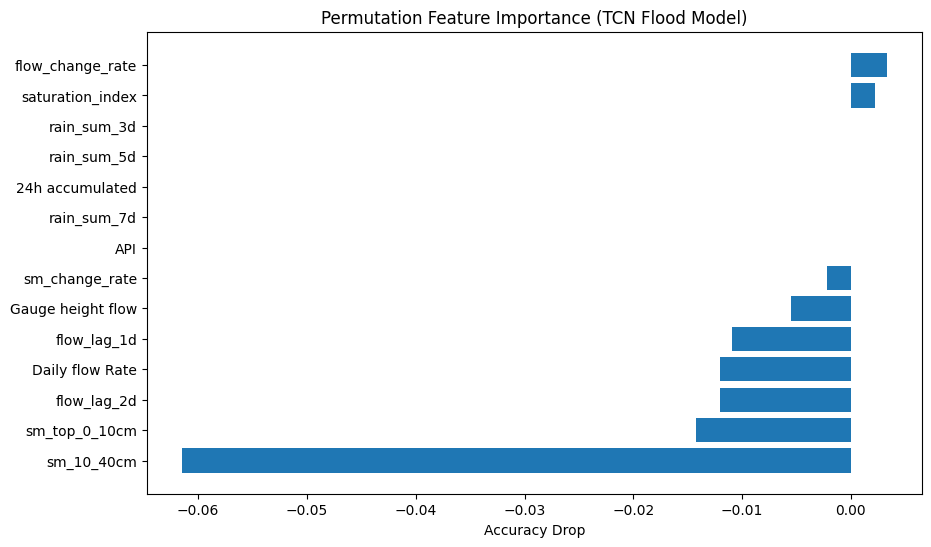

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(importance_df['feature'], importance_df['importance_drop'])
plt.gca().invert_yaxis()
plt.xlabel('Accuracy Drop')
plt.title('Permutation Feature Importance (TCN Flood Model)')
plt.show()


In [ ]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Average saliency over multiple samples
num_samples = min(100, len(X_test_fold))
saliency_sum = np.zeros((WINDOW_SIZE, len(features)))

for i in range(num_samples):
    x = tf.convert_to_tensor(X_test_fold[i:i+1], dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(x)
        preds = model(x)
        cls = tf.argmax(preds[0])
        score = preds[0, cls]
    grads = tape.gradient(score, x).numpy()[0]
    saliency_sum += np.abs(grads)

saliency_avg = saliency_sum / num_samples


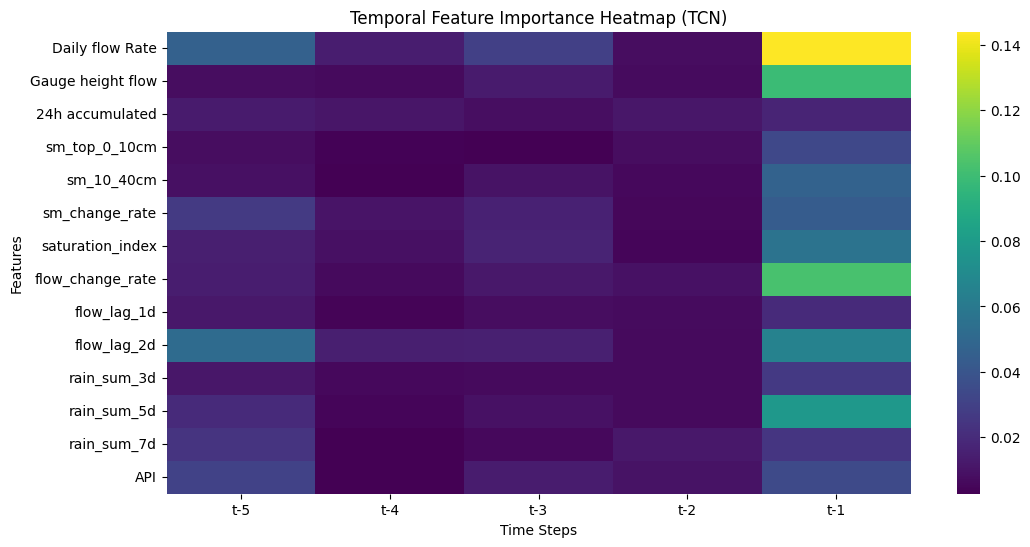

In [ ]:
plt.figure(figsize=(12,6))
sns.heatmap(
    saliency_avg.T,
    xticklabels=[f"t-{i}" for i in range(WINDOW_SIZE, 0, -1)],
    yticklabels=features,
    cmap="viridis"
)
plt.xlabel("Time Steps")
plt.ylabel("Features")
plt.title("Temporal Feature Importance Heatmap (TCN)")
plt.show()


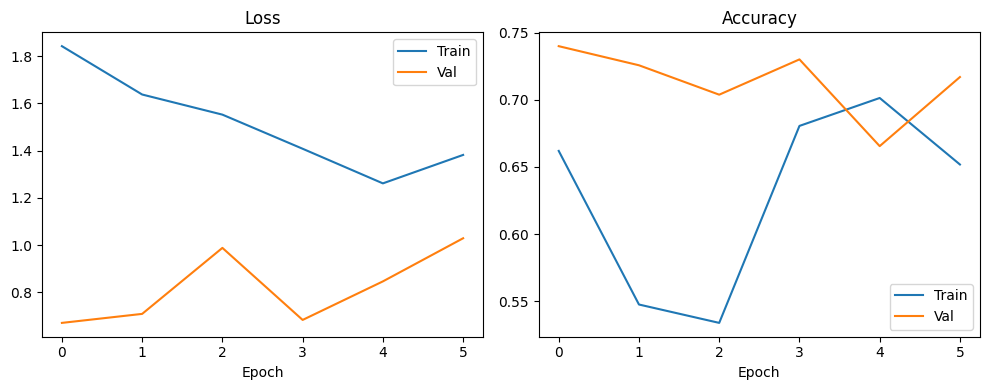

In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()



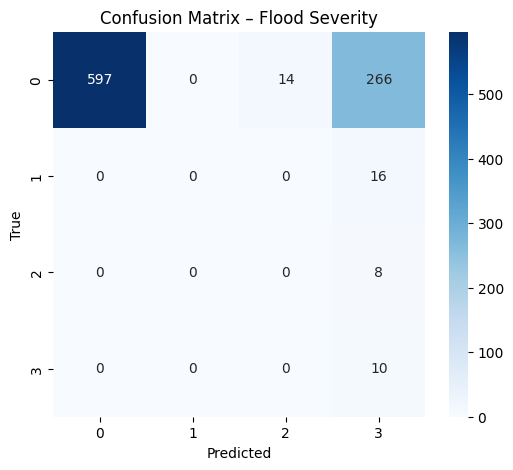

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[0,1,2,3],
            yticklabels=[0,1,2,3])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – Flood Severity")
plt.show()


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(
    y_true, y_pred,
    target_names=['No Flood','Minor','Moderate','Severe']
))


              precision    recall  f1-score   support

    No Flood       1.00      0.68      0.81       877
       Minor       0.00      0.00      0.00        16
    Moderate       0.00      0.00      0.00         8
      Severe       0.03      1.00      0.06        10

    accuracy                           0.67       911
   macro avg       0.26      0.42      0.22       911
weighted avg       0.96      0.67      0.78       911



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
